In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch_scatter import scatter_max, scatter_mean
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import re
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
folder_path = r'C:\Users\fardin\Projects\CGNet\Data\TextClassification\IMDB'
# t_tokenizer = TweetTokenizer()
device

device(type='cuda')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
model = AutoModel.from_pretrained("microsoft/deberta-v3-large")
id_vocab = {v:k for k,v in tokenizer.vocab.items()}
all_vocab_indices = list(id_vocab.keys())

with open(r'Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
token_vocab_dict = dict(zip(all_vocab_str, embeddings))

with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)
polarities_subjectivities.shape
for i in range(len(all_vocab_str)):
    if 'nice' in all_vocab_str[i]:
        print(i, polarities_subjectivities[i])
        break

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


1085 tensor([0.7000, 0.6000], dtype=torch.float64)


In [4]:
keep_ratio = 0.04
test_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')
test_df['Topic'] = test_df['label']
test_df['Content'] = test_df['text']
test_df.drop(['label', 'text'], axis=1, inplace=True)
test_df.dropna(inplace=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.iloc[:int(keep_ratio*test_df.shape[0])]
train_df = pd.read_csv(r'data\TextClassification\IMDB\train.csv')
train_df['Topic'] = train_df['label']
train_df['Content'] = train_df['text']
train_df.drop(['label', 'text'], axis=1, inplace=True)
train_df.dropna(inplace=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.iloc[:int(keep_ratio*train_df.shape[0])]
sst_classes = ["Negative", "Positive"]
df = pd.DataFrame(np.concatenate([train_df.values, test_df.values]), columns=train_df.columns)
class_id = {c:i for i, c in enumerate(sst_classes)}
id_class = {i:c for i, c in enumerate(sst_classes)}
df.shape

(2000, 2)

In [5]:
# %%time
vocabs_lists = list(token_vocab_dict.keys())
term_frequencies = {t:1 for t in vocabs_lists}
temp_term_frequencies = {}

for doc in train_df.Content.values:
    tokens_list = tokenizer.tokenize(doc)
    new_tokens = {t.strip('▁').lower() for t in tokens_list}
    for t in new_tokens:
        if t not in temp_term_frequencies:
            temp_term_frequencies[t] = 0
        temp_term_frequencies[t] += 1
        
for k, v in term_frequencies.items():
    stripped_token = k.strip('▁').lower()
    term_frequencies[k] = temp_term_frequencies[stripped_token] if stripped_token in temp_term_frequencies else 1


In [6]:
threshold = 0.00001
total_token_count = np.array(list(term_frequencies.values())).sum()
one_tensor = torch.tensor(1)
def subsampling_equation_linear(x: torch.Tensor):
    f_x = x/total_token_count
    x = torch.min(one_tensor, torch.sqrt_(threshold/f_x))
    return x

def subsampling_equation_sigmoid(x: torch.Tensor):
    f_x = x/total_token_count
    x = 1-0.95*F.sigmoid(0.05*((f_x/threshold)-90))
    return x

In [7]:
# from utilities.data_manager.CharacterandTokenLevelCustomDataset import CharacterandTokenLevelCustomDataset
from utilities.data_manager.CharacterandTokenLevelDataLoader import CharacterandTokenLevelDataLoader

In [8]:
tokenizer.vocab['good']
id_vocab[1]

'[CLS]'

In [80]:

import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from torch_geometric.data import Batch, Data
import random

class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, num_classes, token_dict, sentiment_dict, tokenizer, vocab, token_frequencies, sampling_equation, id_class, shuffle=True, batch_size=128) -> None:
        super().__init__()
        if len(X) % batch_size != 0:
            self.shortage = ((len(X) // batch_size)+1)*batch_size - len(X)
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            X = np.concatenate([X, empty_strings])
        
        self.shuffle = shuffle
        self.X = X
        self.vocab_size = 16384
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.token_dict = token_dict
        self.embedding_size = token_vocab_dict[next(iter(token_dict))].shape[0]
        self.zero_emb = torch.zeros((self.embedding_size,), dtype=torch.float32)
        self.sentiment_dict = sentiment_dict
        self.token_frequencies = token_frequencies
        self.max_token_count = 0
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            g_data = self.content_to_graph(doc, sampling_equation)
            self.all_data.append(g_data)
        
        
        self.num_sections = len(X) // batch_size
        self.x_lengths = np.array([self.all_data[i].character_length for i in range(len(self.all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]
        

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        
    def __getitem__(self, index):
        index = self.get_section_index()
        ds = self.all_data[index]
        cs_pos = ds.cumulative_pos
        random_token_id= max(1, random.randint(ds.num_tokens//2 - 1 , ds.num_tokens-2))
        new_data = Data(
            x=ds.x[:cs_pos[random_token_id-1]+1],
            character_length=cs_pos[random_token_id-1]+1,
            num_tokens = random_token_id+1,
            token_indices = ds.token_indices[:cs_pos[random_token_id-1]+1],
            token_lengths = torch.cat([ds.token_lengths[:random_token_id], ds.token_lengths[-1].unsqueeze(0)], dim=0),
            token_embeddings = torch.cat([ds.token_embeddings[:random_token_id],ds.token_embeddings[-1].unsqueeze(0)], dim=0),
            token_sentiments = torch.cat([ds.token_sentiments[:random_token_id],ds.token_sentiments[-1].unsqueeze(0)], dim=0),
            token_subsampling_probabilities = torch.cat([ds.token_subsampling_probabilities[:random_token_id],ds.token_subsampling_probabilities[-1].unsqueeze(0)], dim=0)
            ) 
        new_data.x[-1] = 16300
        label = ds.token_ids[random_token_id]
        return new_data, label
        
    def __len__(self):
        return len(self.X)
    
    def get_section_index(self):
        target_index = self.sections[self.section_i, self.position_j]
        
        self.position_j = (self.position_j + 1) % self.section_size
        if self.position_j == 0:
            self.section_i = (self.section_i + 1) % self.num_sections
            if self.shuffle and self.section_i == 0:
                self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return target_index

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
        return np.array(groups), groups_size
        
    def content_to_graph(self, doc, sampling_equation):
        tokens = self.tokenizer(doc)
        if len(tokens) == 0:
            tokens = ['empty']
        # while len(tokens) < 3:
        #     tokens.append('[PAD]')
            
        token_lengths = [len(t) for t in tokens]
        tokens.append('\x01')
        
        token_lengths.append(len(tokens[-1])-1)
        token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
        token_embs = [self.token_dict[t] if t in self.token_dict else self.zero_emb for t in tokens]
        token_ids = torch.from_numpy(np.array([self.vocab[t] if t in self.vocab else 0 for t in tokens], dtype=np.longlong))
        token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
        token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
        token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
        doc = ' '.join(tokens)
        characters = torch.from_numpy(np.array([ord(t) if ord(t)<16383 else 16383 for t in doc], dtype=np.longlong))
        token_positions = torch.arange(len(token_lengths), dtype=torch.long)
        token_indices = torch.repeat_interleave(token_positions, token_lengths)
        token_subsampling_probabilities = sampling_equation(torch.from_numpy(np.array([self.token_frequencies[t] if t in self.token_frequencies else 1 for t in tokens])))
        num_tokens = len(token_lengths)
        if num_tokens > self.max_token_count:
            self.max_token_count = num_tokens
        
        cumulative_pos = torch.cumsum(token_lengths, dim=0)    
        
        g_data = Data(x=characters,
                        # token_positions=token_positions,
                        token_ids = token_ids,
                        character_length = len(characters),
                        num_tokens = num_tokens,
                        token_indices=token_indices,
                        token_lengths=token_lengths,
                        token_embeddings=token_embs,
                        token_sentiments=token_sentiments,
                        cumulative_pos=cumulative_pos,
                        token_subsampling_probabilities=token_subsampling_probabilities)
        return g_data
 
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices       

In [81]:
%%time
train_dataset = CharacterandTokenLevelCustomDataset(train_df.Content.values, len(class_id), token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, tokenizer.vocab, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, id_class=id_class, batch_size=batch_size)
test_dataset = CharacterandTokenLevelCustomDataset(test_df.Content.values, len(class_id), token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, tokenizer.vocab, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, id_class=id_class, batch_size=batch_size)
max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

100%|██████████| 1024/1024 [00:15<00:00, 65.84it/s] 

CPU times: total: 2min
Wall time: 31.6 s


In [82]:
X, y = next(iter(train_dataloader))

In [83]:
ds1 = train_dataset[0][0]
ds2 = train_dataset[0][0]

In [84]:
ds1.num_tokens

963

In [85]:
ds1.token_embeddings.shape

torch.Size([963, 64])

In [86]:
chr(16380)

'㿼'

In [87]:
print(ds1.x)
ds2.x[-1] = 16380
print(ds2.x)

tensor([ 9601,    73,   116,  ...,   115,    32, 16300])
tensor([ 9601,    65,    32,  ...,   102,    32, 16380])


In [88]:
# random_token_id= 407 #random.randint(ds.num_tokens//2, ds.num_tokens-1)
# cs_pos = torch.cumsum(ds.token_lengths, dim=0)
# new_data = Data(
#     x=ds.x[:cs_pos[random_token_id-1]],
#     character_length=cs_pos[random_token_id-1],
#     num_tokens = random_token_id,
#     token_indices = ds.token_indices[:cs_pos[random_token_id-1]],
#     token_lengths = ds.token_lengths[:random_token_id],
#     token_embeddings = ds.token_embeddings[:random_token_id],
#     token_sentiments = ds.token_sentiments[:random_token_id],
#     token_subsampling_probabilities = ds.token_subsampling_probabilities[:random_token_id]
#     ) 
# label = ds.x[cs_pos[random_token_id-1]:cs_pos[random_token_id-1]+ds.token_lengths[random_token_id]]
# print(''.join([chr(id) for id in new_data.x[-new_data.token_lengths[-1]:]]))
# print(''.join([chr(id) for id in label]))

In [89]:
# lngths = np.array([len(dss.token_lengths) for dss in train_dataset2.all_data])

In [90]:
# lngths.min()

In [91]:
# lngths = np.array([len(dss[0].token_lengths) for dss in train_dataset])

In [92]:
ds3 = X.to_data_list()[-1]

In [93]:
''.join([chr(tid) for tid in ds3.x])

'▁Positive 㾬'

In [94]:
from utilities.model_layers.GCNN import GCNN
from utilities.model_layers.GenGraph2 import GenGraph
from utilities.model_layers.SentimentInjection import SentimentInjection

5_restructure_for_contrastive_learning

In [115]:
class CGNetTokenLevelEmbedding(nn.Module):
    def __init__(self, embedding_dim=64, hidden_dim=64, dropout=0.2, seed=-1, random_edges=4, lattice_edges=10, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, step_of_test = 0, head=1, *args, **kwargs):
        super(CGNetTokenLevelEmbedding, self).__init__(*args, **kwargs)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.step_of_test = step_of_test
        if seed>-1:
            torch.manual_seed(seed)
        self.embedding = nn.Embedding(16384, embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*embedding_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.sentiment1  = SentimentInjection(hidden_dim, embedding_dim)
        self.sentiment2  = SentimentInjection(hidden_dim, embedding_dim)
        self.p_layer_1 = nn.Linear(hidden_dim, head)
        self.gcnn1 = GCNN(hidden_dim)
        self.p_layer_2 = nn.Linear(hidden_dim, head)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, 0, lattice_step, head=head)
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * 4)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        cumulative_token_indices = self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, cumulative_token_indices, dim=1)
        x = torch.cat([x1, x2], dim=0)
        x = F.relu(self.conv3(x))
        x = self.sentiment1(x.T, token_sentiments)
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
        p = self.p_layer_1(x.T)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.gen_graph(x, p, len(token_lengths), num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        x, edge_weights, edge_index = self.gcnn1(graph.x.T, graph.edge_index, return_attention_weights = True)
        edge_weights = edge_weights[1].unsqueeze(-1)
        edge_weights = edge_weights[:edge_weights.shape[0], 0]
        
        p = self.p_layer_2(x)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, edge_index, p, len(token_lengths), num_tokens, rand_edges-1, lattice_edges-1, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        x = self.sentiment2(x, token_sentiments)
        xa = graph.x[:token_embeddings.shape[0]]
        xb = token_embeddings
        x = torch.cat([xa, xb], dim=1)
        x1 = F.relu(self.fc0(graph.x[token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        x, edge_weights, edge_index = self.gcnn2(x, graph.edge_index)
        x = self.fc1(x)
        return x
    
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices

In [116]:
class CGNetEmbedding(nn.Module):
    def __init__(self, token_embedding_model, hidden_dim=64, output_dim=512, *args, **kwargs):
        super(CGNetEmbedding, self).__init__(*args, **kwargs)
        self.token_embedding_model = token_embedding_model
        self.fc2 = nn.Linear(hidden_dim * 8 , output_dim)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        x = self.token_embedding_model(x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings)
        x = F.elu_(x)
        doc_token_index = torch.repeat_interleave(torch.arange(len(num_tokens), device=x.device), num_tokens)
        x1 = scatter_max(x[:len(token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(token_lengths)], doc_token_index, dim=0)
        x_for_cat = [x1, x2]
        x = torch.cat(x_for_cat, dim=1)
        x = self.fc2(x)
        return x
    

In [117]:
len(id_vocab)

128001

In [118]:
class CNN_for_Text_No_Positional_Encoding(nn.Module):
    
    def __init__(self, embedding_model: CGNetEmbedding, hidden_dim=64, dropout=0.3, num_out_features=len(id_vocab), *args, **kwargs) -> None:
        super(CNN_for_Text_No_Positional_Encoding, self).__init__(*args, **kwargs)
        self.embedding_model = embedding_model
        self.num_out_features= num_out_features
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, self.num_out_features)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        x = F.elu_(self.embedding_model(x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths=token_lengths, num_tokens=num_tokens, character_length=character_length, token_embeddings=token_embeddings))
        x = self.dropout(x)
        return self.fc_out(x)

In [119]:
# for p1 in [False, True]:
#     for p2 in [False, True]:
#         for p3 in [False, True]:
# print(f'\n{p1}, {p2}, {p3}: \n')
token_embedding_model = CGNetTokenLevelEmbedding(embedding_dim=64, hidden_dim=128, dropout=0.2,  seed=911, random_edges=4, lattice_edges=4, lattice_step=2, lattice_start_distance=2)
embedding_model = CGNetEmbedding(token_embedding_model, hidden_dim=128, output_dim=256).eval()

# embedding_model = CGNetEmbedding(embedding_dim=64, hidden_dim=128, dropout=0.2,  seed=911, random_edges=4, lattice_edges=4, lattice_step=2, lattice_start_distance=2)
classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=256, dropout=0.2, num_out_features=len(id_vocab)).eval()
flopt_counter = FlopCounterMode(classifier_torch_model)
with flopt_counter:
    # embedding_model(X.x, torch.zeros((2, 0)), X.token_subsampling_probabilities, X.token_indices, X.token_sentiments, token_lengths=X.token_lengths, num_tokens=X.num_tokens, character_length=X.character_length, token_embeddings=X.token_embeddings)
    classifier_torch_model(X.x, torch.zeros((2, 0)), X.token_subsampling_probabilities, X.token_indices, X.token_sentiments, X.token_lengths, X.num_tokens, X.character_length, X.token_embeddings)

Module                                                   FLOP    % Total
----------------------------------------------------  -------  ---------
CNN_for_Text_No_Positional_Encoding                   88.229B    100.00%
 - aten.convolution                                   54.649B     61.94%
 - aten.addmm                                         33.580B     38.06%
 CNN_for_Text_No_Positional_Encoding.embedding_model  71.452B     80.98%
  - aten.convolution                                  54.649B     61.94%
  - aten.addmm                                        16.802B     19.04%
 CNN_for_Text_No_Positional_Encoding.fc_out           16.777B     19.02%
  - aten.addmm                                        16.777B     19.02%


In [100]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [101]:
# Fardin Rastakhiz @ 2023
import torch
# from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L
from utilities.managers.ModelManager import ModelManager
from utilities.callbacks.CustomModelCheckpoint import CustomModelCheckpoint

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            CustomModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True, save_weights_only=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        # if(give_hinge_loss):
        #     print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        
        model = self.trainer.model.model
        # self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.lightning_model.model.load_state_dict(torch.load(rf'{self.trainer.checkpoint_callback.best_model_path}', weights_only=True, map_location=None))
        self.save_evaluation(self.lightning_model, eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, model, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            model = model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                # if(give_hinge_loss):
                #     print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [102]:
from utilities.managers.ModelManager import ModelManager
from utilities.managers.ClassifierModelManager import ClassifierModelManager
from utilities.lightning_models.CGNetEmbeddingLightningModel import CGNetEmbeddingLightningModel

In [103]:
output_size = 64
hidden_dim = 64
embedding_dim = 64
seed = 911

In [120]:
import torch
import lightning as L
import torchmetrics

class CGNetEmbeddingLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CGNetEmbeddingLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x.x, torch.zeros((2, 0)), x.token_subsampling_probabilities, x.token_indices, x.token_sentiments, x.token_lengths, x.num_tokens, x.character_length, x.token_embeddings)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)
        
        loss = self.loss_func(y_out, F.one_hot(y, y_out.shape[1]).float())
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), y)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out, F.one_hot(y, y_out.shape[1]).float())
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), y)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [121]:
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True, use_positional_encoder=[False, False, False]):
    torch.autograd.set_detect_anomaly(True)
    
    
    token_embedding_model = CGNetTokenLevelEmbedding(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=dropout,  seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, lattice_start_distance=2).to(device)
    embedding_model = CGNetEmbedding(token_embedding_model, hidden_dim=hidden_dim, output_dim=256).to(device)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=256, dropout=dropout, num_out_features=len(id_vocab)).to(device)
        
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CGNetEmbeddingLightningModel(classifier_torch_model, 
                                                        num_classes=len(id_vocab),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name=f'CNN-GNN_{use_positional_encoder[0]}_{use_positional_encoder[1]}_{use_positional_encoder[2]}',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.lightning_model.model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(model_manager.lightning_model, test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [122]:
torch.cuda.empty_cache()
import gc
gc.collect()

4238

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 34.3 M | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassAccuracy                  | 0      | train
3 | val_acc   | MulticlassAccuracy                  | 0      | train
4 | test_acc  | MulticlassAccuracy                  | 0      | train
--------------------------------------------------------------------------
34.3 M    Trainable params
0         Non-trainable params
34.3 M    Total params
137.234   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


torch.Size([1024])
torch.Size([1024, 128001])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

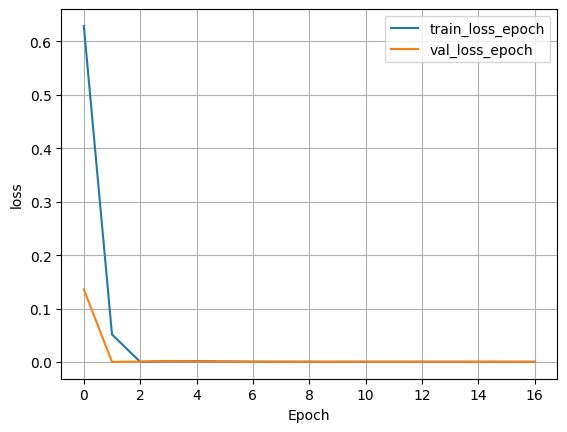

In [123]:
model_manager = train_model(70, 0.2, 0.000012, 0.0032, use_positional_encoder=[False, False, False])

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

def calculatge_metrics(chpt_path, target_data_loader):
    
    embedding_model = CGNetEmbedding(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=0.2,  seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, lattice_start_distance=2)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=hidden_dim, dropout=0.2, num_out_features=len(class_id))
    
    classifier_torch_model.load_state_dict(torch.load(chpt_path, weights_only=True, map_location="cuda:0"))
    classfier_lightning_model = CGNetEmbeddingLightningModel(classifier_torch_model, 
                                                    num_classes=len(class_id),
                                            batch_size=batch_size,
                                            user_lr_scheduler=True
                                            ).to(device).eval()
    
    mean_infer_acc = []
    mean_infer_f1 = []
    mean_infer_prec = []
    mean_infer_rec = []
    for i in range(5):
        all_ys = []
        all_y_preds = []
        for X, y in target_data_loader:
            with torch.no_grad():
                y_pred = classfier_lightning_model(X.to(device))
            all_ys.append(torch.argmax(y,dim=1))
            all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
        all_ys = torch.concat(all_ys)
        all_y_preds = torch.concat(all_y_preds)
        
        cm = confusion_matrix(all_ys, all_y_preds, labels=list(id_class.keys()))
        
        accuracy = np.sum(np.diag(cm))/ np.sum(cm)
        precision = np.mean(np.diag(cm) / (np.sum(cm, axis=0)+0.000001))
        recall = np.mean(np.diag(cm) / (np.sum(cm, axis=1)+0.000001))
        f1_score = (2*precision*recall)/(precision + recall+0.000001)
        
        mean_infer_acc.append(accuracy)
        mean_infer_f1.append(f1_score)
        mean_infer_prec.append(precision)
        mean_infer_rec.append(recall)
    mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
    mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
    mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
    mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
    return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec, classfier_lightning_model

In [25]:
from os import listdir
from os.path import isfile, join
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [26]:
def calculate_average_metrics_mean(base_path = 'logs\CNN-GNN18_mr2k_seeds', start=0, interval=1):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []
    
    for i in range(start, start + interval):
        version_path = join(base_path, f'version_{i}')
        checkpoint_path = join(version_path, f'checkpoints')
        onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
        epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
        best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
        print(onlyfiles[best_chpt_id])
        mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec, classfier_lightning_model = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader)
            
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)
        total_loss.append(loss)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')
    return classfier_lightning_model

In [28]:
classfier_lightning_model = calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_False', start=27)

epoch=26-step=2646.pth


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


total_accuracy: 0.9081951530612244
total_f1: 0.9082070482356379
total_prec: 0.9082199438493459
total_rec: 0.9081951529888237
total_loss: 0.2710480690002441


In [ ]:
classfier_lightning_model = calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_False', start=25)

epoch=52-step=20723.pth


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


total_accuracy: 0.9022218670076727
total_f1: 0.9022369648498394
total_prec: 0.9022530633260486
total_rec: 0.9022218669355642
total_loss: 0.250955730676651
